# Grid Search

The SVM classifier requires two regularization parameters, C and gamma. To tune these parameters, we need to do a grid search. Scikit-learn has a built in grid search function, but it only reports overall correctness of the predictions, and we want more detailed information such as:
* How good is the model at predicting bad outages (3 - 7 outages)?
* How good is the model at predicting extreme outages (8+ outages)?
* How often does the model give false positives?
* How does all of this relate to each other and overall correctness?

To do this, we implement a custom grid search. First, import the appropriate modules.

In [1]:
from sklearn.svm import SVC
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ShuffleSplit
from matplotlib import pyplot as plt
%matplotlib inline

Now we need to import the appropriate dataset for SVM.

In [2]:
data = pd.read_csv("../../Data/WeatherOutages_SVM.csv")

In [3]:
data.head()

,Total_outages,Day_length_hr,Avg_Temp_F,Avg_humidity_percent,Max_windspeed_mph,Avg_windspeed_mph,Max_windgust_mph,Precipitation_in
0,0,12.783333,58,89,8,2,9,0.01
1,2,12.716667,62,69,8,4,9,0.00
2,1,12.666667,64,74,16,7,25,0.00
3,0,12.616667,71,66,17,12,9,0.00
4,1,12.550000,66,79,12,5,9,0.00


Classify the number of outages into 3 categories:
* 0: 0 - 2 outages (normal)
* 1: 3 - 7 outages (bad)
* 2: 8+ outages (extreme)

In [4]:
for i in range(data.shape[0]):
    if data.iloc[i].Total_outages < 3:
        data.loc[i, "outage_class"] = int(0)
    elif data.iloc[i].Total_outages > 7:
        data.loc[i, "outage_class"] = int(2)
    else:
        data.loc[i, "outage_class"] = int(1)

In [5]:
data.head()

,Total_outages,Day_length_hr,Avg_Temp_F,Avg_humidity_percent,Max_windspeed_mph,Avg_windspeed_mph,Max_windgust_mph,Precipitation_in,outage_class
0,0,12.783333,58,89,8,2,9,0.01,0.0
1,2,12.716667,62,69,8,4,9,0.00,0.0
2,1,12.666667,64,74,16,7,25,0.00,0.0
3,0,12.616667,71,66,17,12,9,0.00,0.0
4,1,12.550000,66,79,12,5,9,0.00,0.0


Finally we do the grid search. The following code will perform a grid search. Parameters such as the exploration values of C and gamma, etc can be changed. But the following was what was used in this project.

In [35]:
# Define variables
xTrain = None
yTrain = None
xTest = None
yTest = None

# Define objects and parameters. Here, we have defined the test data set to be 20%, balanced weight for SVM.
# And we are exploring C and gamma from 10e-5 to 10e5
nSplits = 10
scaler = StandardScaler()
shuffleSplitter = ShuffleSplit(n_splits=nSplits, test_size=0.2)
classifier = SVC(cache_size=1000.0, class_weight="balanced", probability=True)
exploreC = np.logspace(-5, 5, 1)
exploreGamma = np.logspace(-5, 5, 1)
outputFilename = "filename.csv"
df = pd.DataFrame()

# For each values of C and gamma we want to explore, we will shuffle split 10 times, store them in an empty array,
# and then average them.
for cValue in exploreC:
    for gammaValue in exploreGamma:
        classifier.set_params(C = cValue, gamma = gammaValue)
        allCorrectness = []
        allFalseNegativesBad = []
        allFalseNegativesExtreme = []
        allFalsePositives = []
        allBadDays = []
        allExtremeDays = []
        
        # Separate testing and training data.
        for train, test in shuffleSplitter.split(data):
            overallCorrectness = 0
            falseNegativesBad = 0
            falseNegativesExtreme = 0
            falsePositives = 0
            badDays = 0
            extremeDays = 0
            xTrain = scaler.fit_transform(data.iloc[train, 1:-1])
            yTrain = data.iloc[train, -1]
            xTest = scaler.transform(data.iloc[test, 1:-1])
            yTest = data.iloc[test, -1]
            classifier.fit(xTrain, yTrain)
            yPredict = classifier.predict(xTest)
            yTest = yTest.tolist()
            yPredict = yPredict.tolist()
            
            #Compare testing data and predicted data from model. Tally up the results.
            for i in range(len(yTest)):
                if yTest[i] == 1:
                    badDays += 1
                elif yTest[i] == 2:
                    extremeDays += 1
                if yTest[i] == yPredict[i]:
                    overallCorrectness += 1
                elif yTest[i] < yPredict[i]:
                    falsePositives += 1
                elif yTest[i] == 1 and yPredict[i] == 0:
                    falseNegativesBad += 1
                else: # yTest[i] == 2 and yPredict[i] != 2
                    falseNegativesExtreme += 1
            allCorrectness.append(overallCorrectness / len(yTest))
            allBadDays.append(badDays)
            allExtremeDays.append(extremeDays)
            if badDays != 0:
                allFalseNegativesBad.append(falseNegativesBad / badDays)
                allFalsePositives.append(falsePositives / (badDays + extremeDays))
            else:
                allFalseNegativesBad.append(0)
                allFalsePositives.append(0)
            if extremeDays != 0:
                allFalseNegativesExtreme.append(falseNegativesExtreme / extremeDays)
            else:
                allFalseNegativesExtreme.append(0)
            
        df = df.append({"C": cValue, "gamma": gammaValue, "Overall_Correctness": np.mean(allCorrectness),
                         "False_Negatives_Extreme": np.mean(allFalseNegativesExtreme),
                        "False_Negatives_Bad": np.mean(allFalseNegativesBad),
                        "False_Positives": np.mean(allFalsePositives),
                       "Bad_Days": np.mean(allBadDays),
                        "Extreme_Days": np.mean(allExtremeDays)}, ignore_index = True)
df.to_csv(outputFilename)

In the output CSV note that:
* False negatives extreme is the number of false negatives on extreme days normalized by the number of extreme days
* False negatives bad is the number of false negatives on bad days normalized by the number of bad days
* False positives is the number of false posittives normalized by the sum of bad and extreme days. This value can be more than 1 if there are more false positives than there are of actual bad and extreme days
* Bad days is the number of bad days
* Extreme days is the number of extreme days
* Overall correctness is the rate at which the model correctly predicts the classification of outages.

Of course, all these numbers are averaged over the 10 shuffle splits.

### Visualizing grid search
We can plot the results of the grid search to visually inspect the SVM model. Here, we demonstrate plotting the overall correctness of the model, though this code snippet can be easily changed. For demonstration, we load the a past grid search. The code snippet can spit out a png image if the last line is uncommented.

In [6]:
gridSearch = pd.read_csv("gridSearch.csv")
gridSearch.head()

,C,gamma,False_Negatives_Bad,False_Negatives_Extreme,False_Positives,Overall_Correctness,Bad_Days,Extreme_Days
0,0.00001,0.00001,0.3,0.5,5.745204,0.293027,135.2,14.1
1,0.00001,0.00010,0.6,0.8,3.308781,0.552162,135.2,13.7
2,0.00001,0.00100,0.5,0.9,3.901914,0.481995,135.2,14.4
3,0.00001,0.01000,0.3,0.8,5.427809,0.323036,135.2,14.5
4,0.00001,0.10000,0.8,1.0,1.530679,0.728332,135.2,13.3


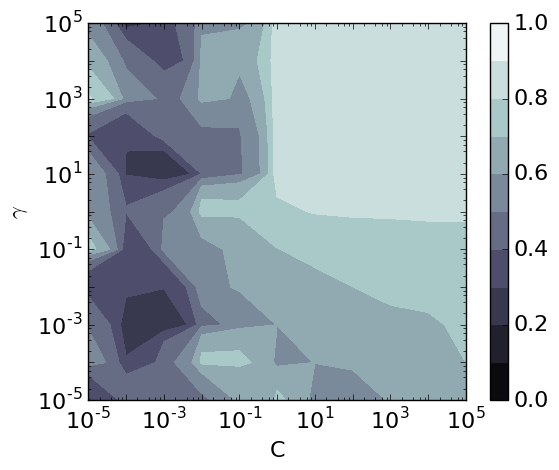

In [7]:
N=11
M=11 

X=gridSearch.C.values.reshape([N,M]) #output = NxM matrix value of our X's 
Y=gridSearch.gamma.values.reshape([N,M]) #output = NxM matrix of our Y's 
Z=gridSearch.Overall_Correctness.values.reshape([N,M]) #output = NxM matrix of unique z values

spacer = 0.1
lines = 10
levels=np.linspace(0,lines*spacer,num=(lines+1),endpoint=True)

fig=plt.figure(figsize=(6,5)) 
ax = fig.add_subplot(111)
plt.contourf(X,Y,Z, levels, cmap=plt.cm.bone)
plt.xlabel("C")
plt.ylabel(r"$\gamma$")
plt.xscale("log")
plt.yscale("log")
plt.colorbar()
plt.rcParams.update({'font.size': 16, "axes.labelsize": "large"})
for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)
for label in ax.yaxis.get_ticklabels()[::2]:
    label.set_visible(False)
plt.tight_layout()
# plt.savefig("GridSearch_OverallCorrectness.png")

For the actual python package, we chose C = 10.0 and gamma = 0.01. This can be easily changed in the future.